In [1]:
import requests
import pandas as pd

In [2]:
base_url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-commune/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
response = requests.get(base_url)
response.raise_for_status()

In [3]:
filename = "georef-france-commune.csv"
with open(filename, "wb") as f:
    f.write(response.content)
print(f"Downloaded {filename}")

Downloaded georef-france-commune.csv


In [6]:
data.columns

Index(['Geo Point', 'Nom Officiel Département', 'Nom Officiel Commune'], dtype='object')

In [16]:
data = pd.read_csv(
    filename,
    delimiter=";",
    usecols=[
        "Geo Point",
        "Nom Officiel Département",
        "Nom Officiel Commune",
        # "Code Canton Ville",
    ],
)

In [9]:
data.to_parquet("georef-france-commune.parquet")

In [10]:
data.head()

,Geo Point,Nom Officiel Département,Nom Officiel Commune
0,"44.05663317511026, 6.080498812220846",Alpes-de-Haute-Provence,Mirabeau
1,"44.019569849537234, 5.823167584619715",Alpes-de-Haute-Provence,Revest-Saint-Martin
2,"43.90416218986043, 5.616017596751714",Alpes-de-Haute-Provence,Sainte-Croix-à-Lauze
3,"44.471613451136896, 6.1595420491675075",Hautes-Alpes,Remollon
4,"45.00016914643277, 6.36413066153131",Hautes-Alpes,Villar-d'Arêne


In [55]:
data.query("`Nom Officiel Commune` == 'Craponne'")

,Geo Point,Nom Officiel Département,Nom Officiel Commune
22184,"45.746009253446125, 4.726884209654968",Rhône,Craponne


In [18]:
data.to_csv("georef-france-commune.csv", index=False)

# Reindex from grid points

In [11]:
from pollen_forecast.copernicus import PollenForcastCopernicusGeneric

In [12]:
my_pollen = PollenForcastCopernicusGeneric(
    north=51.70, south=41.87, east=8.74, west=-5.33, prefix="./france_territory/"
)
my_pollen.get_pollen_data()

2024-06-11 14:49:53,433 INFO Welcome to the CDS
2024-06-11 14:49:53,434 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2024-06-11 14:49:53,479 INFO Request is queued
2024-06-11 14:49:54,517 INFO Request is running


KeyboardInterrupt: 

In [13]:
import xarray as xr

data = xr.open_dataset(my_pollen.filename)
data.coords["longitude"] = (data.coords["longitude"] + 180) % 360 - 180
data_sorted = data.sortby("longitude")
data_sorted

<xarray.Dataset> Size: 5MB
Dimensions:    (latitude: 98, level: 1, time: 96, longitude: 140)
Coordinates:
  * latitude   (latitude) float32 392B 51.65 51.55 51.45 ... 42.15 42.05 41.95
  * level      (level) float32 4B 0.0
  * time       (time) timedelta64[ns] 768B 00:00:00 01:00:00 ... 3 days 23:00:00
  * longitude  (longitude) float32 560B -5.25 -5.15 -5.05 ... 8.45 8.55 8.65
Data variables:
    gpg_conc   (time, level, latitude, longitude) float32 5MB ...
Attributes:
    title:        GRASSPOLLEN Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240526+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of GRASSPOLLEN concentration...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

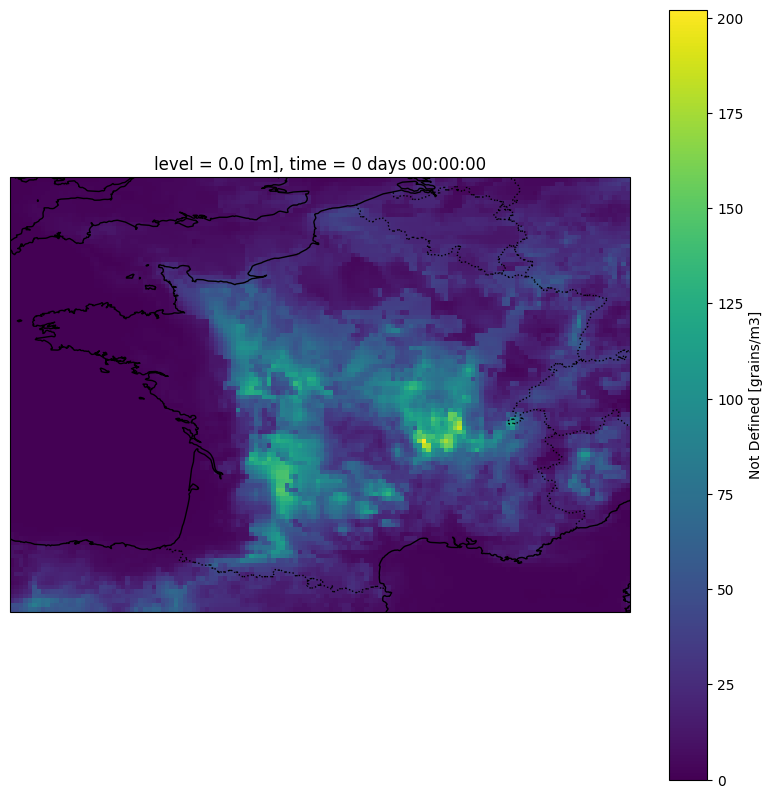

In [14]:
import cartopy
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()})
data_sorted["gpg_conc"].isel(time=0, level=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
)

ax.coastlines()
# add borders
ax.add_feature(cartopy.feature.BORDERS, linestyle=":")

In [19]:
communes = pd.read_csv("georef-france-commune.csv")
communes.head()

,Geo Point,Nom Officiel Département,Nom Officiel Commune
0,"44.05663317511026, 6.080498812220846",Alpes-de-Haute-Provence,Mirabeau
1,"44.019569849537234, 5.823167584619715",Alpes-de-Haute-Provence,Revest-Saint-Martin
2,"43.90416218986043, 5.616017596751714",Alpes-de-Haute-Provence,Sainte-Croix-à-Lauze
3,"44.471613451136896, 6.1595420491675075",Hautes-Alpes,Remollon
4,"45.00016914643277, 6.36413066153131",Hautes-Alpes,Villar-d'Arêne


In [20]:
# find the neasrest grip point of the Xarray Dataset for each commune
def find_nearest_grip_point(lat, long, data):
    print(f"Finding nearest grip point for {lat}, {long}")
    point = data.sel(latitude=lat, longitude=long, method="nearest")
    try:
        lat_nearest = point.latitude.values
        long_nearest = point.longitude.values
    except IndexError:
        print(f"Error with {lat}, {long}")
        print(point.latitude.values)
        print(point.longitude.values)
        return None, None

    return lat_nearest, long_nearest


communes["latitude"], communes["longitude"] = zip(
    *communes.apply(
        lambda x: find_nearest_grip_point(
            x["Geo Point"].split(",")[0], x["Geo Point"].split(",")[1], data_sorted
        ),
        axis=1,
    )
)
communes.head()

Finding nearest grip point for 44.05663317511026,  6.080498812220846
Finding nearest grip point for 44.019569849537234,  5.823167584619715
Finding nearest grip point for 43.90416218986043,  5.616017596751714
Finding nearest grip point for 44.471613451136896,  6.1595420491675075
Finding nearest grip point for 45.00016914643277,  6.36413066153131
Finding nearest grip point for 43.86203079951909,  7.182700023008526
Finding nearest grip point for 43.791275190395446,  7.035701706509597
Finding nearest grip point for 43.72434512377221,  6.963691082414962
Finding nearest grip point for 43.65594768192993,  6.931946365171078
Finding nearest grip point for 43.816587511507706,  7.199541721425961
Finding nearest grip point for 44.12140184485884,  7.118294128298657
Finding nearest grip point for 49.57273569861749,  4.7001324808525915
Finding nearest grip point for 49.40962698197568,  4.209350215741603
Finding nearest grip point for 49.80557404880883,  4.484632447377386
Finding nearest grip point fo

,Geo Point,Nom Officiel Département,Nom Officiel Commune,latitude,longitude
0,"44.05663317511026, 6.080498812220846",Alpes-de-Haute-Provence,Mirabeau,44.05,6.050003
1,"44.019569849537234, 5.823167584619715",Alpes-de-Haute-Provence,Revest-Saint-Martin,44.05,5.850006
2,"43.90416218986043, 5.616017596751714",Alpes-de-Haute-Provence,Sainte-Croix-à-Lauze,43.95,5.649994
3,"44.471613451136896, 6.1595420491675075",Hautes-Alpes,Remollon,44.45,6.149994
4,"45.00016914643277, 6.36413066153131",Hautes-Alpes,Villar-d'Arêne,45.05,6.350006


In [21]:
communes.to_csv("georef-france-commune.csv", index=False)

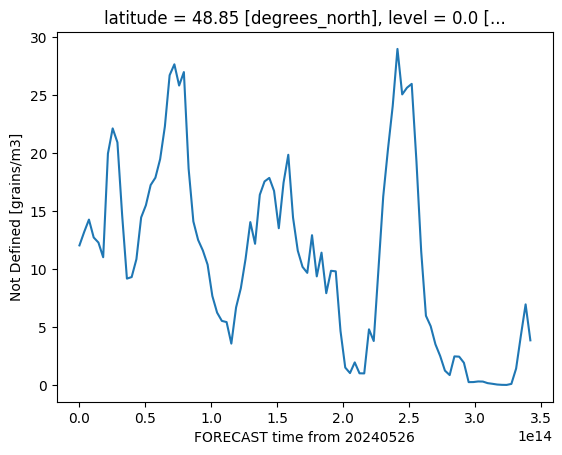

In [49]:
ax = (
    data_sorted["gpg_conc"]
    .sel(level=0, longitude=2.35, latitude=48.85, method="nearest")
    .plot()
)

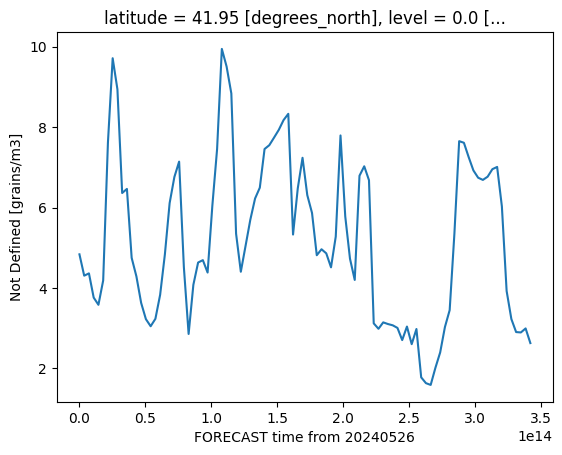

In [48]:
data_sorted["gpg_conc"].sel(
    level=0, latitude=4.85, longitude=45.75, method="nearest"
).plot()